# Q-Learning

관찰을 액션에 직접적으로 매핑하는 함수를 학습하는 정책 경사 방법과 달리, Q-Learning은 각 상태 내에서의 값을 학습하고자 시도하며 그 상태 내에서 특정액션을 취한다. <br>
정책 경사 방법과 Q-Learnin 접근법은 궁극적으로는 주어진 환경 아래 지능적인 액션을 취하게 한다는 점에서 동일 하지만 액션에 도달하는 수단이 다르다. <br>
Deep Q-Learning은 Q-Learning 알고리즘을 더 크고 복잡하게 구현한 것

## Q Table

In [56]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [69]:
# FrozenLake 환경 불러오기
env = gym.make("FrozenLake-v0")

In [74]:
# Q Table 초기화([16, 4], 값은 0)
Q = np.zeros([env.observation_space.n, env.action_space.n])
# 학습 매개변수 설정
lr = .85
y = .99
num_episodes = 2000

# 누적 보상을 담을 리스트 생성
reward_his = []

for i in range(num_episodes):
    # 환경을 리셋하고 첫번째 state획득
    s = env.reset()
    reward_all = 0
    d = False
    
    # Q Table 학습 알고리즘
    for j in range(100):
        # Q Table로부터(노이즈와 함께) 그리디하게 액션 선택
        a = np.argmax(Q[s, :] + np.random.randn(1, env.action_space.n)*(1./(i+1)))
        # 환경으로부터 새로운 상태와 보상을 얻는다.
        s1, r, d, _ = env.step(a)
        # 새로운 지식을 통해 Q Table 업데이트
        Q[s, a] = Q[s, a]+lr*(r+y*np.max(Q[s1, :])-Q[s, a])
        reward_all+=r
        # 기존의 상태 s를 새로 얻은 상태 s1으로 업데이트
        s = s1
        if d == True: # 목적지에 도달하면 두번째 for문 탈출
            break
    reward_his.append(reward_all)

In [76]:
Q

array([[6.36113307e-03, 7.86712068e-03, 3.96652258e-01, 9.97194650e-03],
       [3.14146672e-03, 2.78719762e-03, 2.72995582e-03, 2.61869599e-01],
       [5.36970174e-03, 3.62288040e-03, 5.43019038e-03, 2.60667409e-01],
       [2.63530739e-03, 1.32747107e-03, 1.39599729e-03, 1.84501943e-01],
       [6.33130978e-01, 3.38108438e-03, 3.49727390e-04, 2.84295233e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.94312470e-02, 1.18429508e-04, 4.74359114e-04, 1.80252052e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.41574885e-04, 3.46954978e-04, 8.48121824e-01],
       [0.00000000e+00, 4.99988849e-01, 3.04713856e-04, 3.24084645e-04],
       [2.87232003e-01, 6.70459321e-04, 4.64388641e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.65912733e-03, 1.50060817e-02, 9.76106472e

In [75]:
sum(reward_his)/num_episodes

0.492

## Q-Learning using neural network

테이블을 사용해서 학습하는것은 매우 제한적이다. 실제 환경에서는 테이블로 표현할 수 없을 정도로 큰 상태를 가지고 있기 때문이다. <br>
이에 대한 해결책으로 신경망을 통한 함수근사를 시도한다. 이를 통해 액션에 대한 Q값을 도출 할 수 있다. 

In [4]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
# FrozenLake 환경 불러오기
env = gym.make("FrozenLake-v0")

In [7]:
# 네트워크 구현
# 그래프 초기화
tf.reset_default_graph()

# 액션을 선택하는 데 사용되는 네트워크의 피드포워드 부분
input1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform(shape=[16,4], minval=0, maxval=0.01))
Qout = tf.matmul(a=input1, b=W)
predict = tf.argmax(input=Qout, axis=1)

# 타깃 Q값과 예측 Q값의 차의 제곱합을 통해 비용을 얻는다. 
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(input_tensor=tf.square(x=nextQ-Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [30]:
# 네트워크 학습
init = tf.global_variables_initializer()

# 학습 매개변수 설정
y = 0.99
e = 0.1 # 랜덤한 확률을 취하는 정도
num_episodes = 2000
# 보상의 총계와 에피소드별 단계 수를 담을 리스트 생성
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # 환경을 리셋하고 첫 번째 새로운 관찰을 얻는다.
        s = env.reset()
        rAll = 0
        done = False
        j = 0
        # Q 네트워크
        while j < 99:
            j+=1
            # Q네트워크에서 e의 확률로 랜덤하게 액션을 선택하거나 그리디하게 액션를 선택
            a, allQ = sess.run(fetches=[predict, Qout], feed_dict={input1:np.identity(n=16)[s:s+1, :]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # 환경으로 부터 새로운 상태와 보상을 얻는다. 
            s1, reward, done, _ = env.step(action=a[0])
            # 새로운 상태를 네트워크에 피드해줌으로써 Q`값을 구한다. 
            Q1 = sess.run(fetches=Qout, feed_dict={input1:np.identity(n=16)[s1:s1+1, :]})
            # maxQ`값을 구하고 선택된 액션에 대한 타깃 값을 설정
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = reward+y*maxQ1
            # 타깃 및 예측 Q값을 이용해 네트워크를 학습시킨다.
            _, W1 = sess.run(fetches=[updateModel, W], feed_dict={input1:np.identity(16)[s:s+1], nextQ:targetQ})
            rAll += reward
            s = s1
            if done == True:
                # 모델을 학습하면서 랜덤 액션의 가능성을 줄인다.
                e = 1./((i/50)+10)
                break
        jList.append(j)
        rList.append(rAll)

print("Percent of succesful episodes: " + str(sum(rList)/num_episodes))

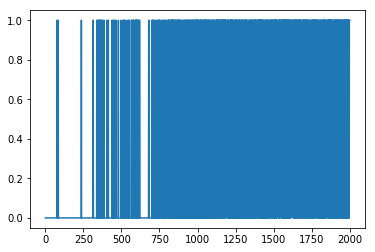

In [32]:
plt.plot(rList)
plt.show()

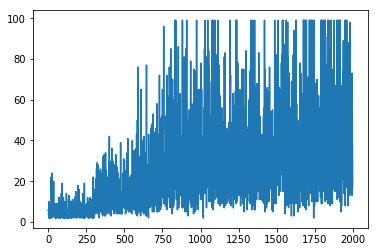

In [33]:
plt.plot(jList)
plt.show()

In [15]:
np.identity(n=16)[1:3,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
env.action_space.sample()

1

In [26]:
env.step(1)

(1, 0.0, False, {'prob': 0.3333333333333333})